In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [68]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [69]:
from torch.nn.functional import softmax

In [70]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


<AxesSubplot: >

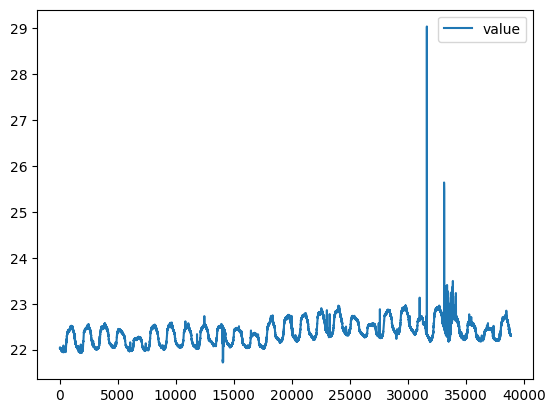

In [71]:
data.plot()

In [72]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment4/online-learning-DLinear']

In [73]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size-1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size-1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [74]:
A=FloatTensor([[[1,2,3]],[[4,5,6]]])
B=FloatTensor([[[1,2,3]],[[4,5,6]]])
C=(A*B).sum(dim=2).view(-1,1,1)
D=FloatTensor([[[1,2,3]],[[4,5,6]]])
E=FloatTensor([[[1,2,3]],[[1,2,3]]])
F=(-1*(torch.abs(D-E).sum(dim=2))).view(-1,1,1)

print(F*E)
print(D[:,:,0:2])
#list_f = [C,F]
# for i in list_f:
#     print(i)
#torch.cat([C,F],dim=2)

torch.cat([FloatTensor(),C],dim=2)

tensor([[[ -0.,  -0.,  -0.]],

        [[ -9., -18., -27.]]])
tensor([[[1., 2.]],

        [[4., 5.]]])


tensor([[[14.]],

        [[77.]]])

In [75]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        self.SMALLKERNEL = 61
        
        # Decomposition Kernel Size
        kernel_size = 61
        self.stride = 1
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        

        self.Linear_Seasonal = nn.Linear(2*self.SMALLKERNEL,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_plus = nn.Linear(2,1)
        
        
#         self.Kernel_Linear = nn.ModuleList()
#         for i in range(seasonal_init.size(-1)//SMALLKERNEL):
#             self.Kernel_Linear.append(nn.Linear())
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device)

        STANDARD = seasonal_init[:,:,-self.SMALLKERNEL:]
        Score_List = []
        Vector_List = []
    
        
        for i in range(self.SMALLKERNEL,seasonal_init.size(-1)-self.SMALLKERNEL+1):
            Comparison_Vector = seasonal_init[:,:,-i-self.SMALLKERNEL:-i]
            Vector_List.append(Comparison_Vector)
            score = (-1*(torch.abs(STANDARD-Comparison_Vector).sum(dim=2))).view(-1,1,1) 
            # 거리를 구한후에 -를 붙여준다
            # 이를 통해 그래프의 모양이 많이 차이나는 것은 가중치를 덜 받게 된다
            Score_List.append(score)
            
        score_tensor = FloatTensor().to(self.device)
        value_tensor = torch.zeros(size=(seasonal_init.size(0),1,self.SMALLKERNEL)).to(self.device)
        
        for i in Score_List:
            score_tensor = torch.cat([score_tensor,i],dim=2)
        
#         print(score_tensor.size())
        Prob_Score = softmax(score_tensor,dim=2)
        
        
#         print(Prob_Score[:,:,0].view(-1,1,1).size())
#         print(Vector_List[0].size())
#         print(value_tensor.size())
        for i in range(Prob_Score.size(2)):
            value_tensor=value_tensor+((Prob_Score[:,:,i].view(-1,1,1))*Vector_List[i])
            # 빈 Tensor와는 덧셈과 같은 텐서연산이 불가능하다
            
        seasonal_input = torch.cat([value_tensor,STANDARD],dim=2)
        seasonal_output = self.Linear_Seasonal(seasonal_input)    
        trend_output = self.Linear_Trend(trend_init)
        new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [76]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [77]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [78]:
torch.manual_seed(42)

In [79]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.99 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [80]:
torch.manual_seed(42)

In [81]:
out_list = []
loss_list = []
time_list1 = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    Start = time.time()
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()   
        
    End = time.time()
    
    time_list1.append(End-Start)
    
    scheduler.step() #schedular update
    
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.9000e-05.
smape 0.08921169803194615 %
Adjusting learning rate of group 0 to 9.8010e-05.
smape 0.07728244336281102 %
Adjusting learning rate of group 0 to 9.7030e-05.
smape 0.0710130637638919 %
Adjusting learning rate of group 0 to 9.6060e-05.
smape 0.067894339530146 %
Adjusting learning rate of group 0 to 9.5099e-05.
smape 0.06606000153996644 %
Adjusting learning rate of group 0 to 9.4148e-05.
smape 0.06492447263165649 %
Adjusting learning rate of group 0 to 9.3207e-05.
smape 0.06413092338228162 %
Adjusting learning rate of group 0 to 9.2274e-05.
smape 0.06348295266636543 %
Adjusting learning rate of group 0 to 9.1352e-05.
smape 0.06303285034298516 %
Adjusting learning rate of group 0 to 9.0438e-05.
smape 0.0626522216745734 %
Adjusting learning rate of group 0 to 8.9534e-05.
smape 0.062341005827316595 %
Adjusting learning rate of group 0 to 8.8638e-05.
smape 0.06209490077341335 %
Adjusting learning rate of group 0 to 8.7752e-05.
smape 0.061869638

In [82]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.007918716205836063 %
SMAPE 0.005689735868713797 %
SMAPE 0.005996410740905844 %
SMAPE 0.012539315863904221 %
SMAPE 0.012249707170923331 %
SMAPE 0.013900637137425063 %
SMAPE 0.01571331795409492 %
SMAPE 0.008580240824358043 %
SMAPE 0.0027180818368890414 %
SMAPE 0.0021638028614887617 %
SMAPE 0.017726382779414962 %
SMAPE 0.00635967664406678 %
SMAPE 0.010781550810769147 %
SMAPE 0.007203007688985963 %
SMAPE 0.0015329715290377521 %
SMAPE 0.060220297949854285 %
SMAPE 0.040658649155375315 %
SMAPE 0.04096443449816434 %
SMAPE 0.019792274148130673 %
SMAPE 0.0021814953874041976 %
SMAPE 0.025948048878603913 %
SMAPE 0.0003160116188212214 %
SMAPE 0.07034363600541838 %
SMAPE 0.00869999664374177 %
SMAPE 0.020385144712349756 %
SMAPE 0.04208568565081805 %
SMAPE 0.032317434430297 %
SMAPE 0.05000432679662481 %
SMAPE 0.062343709520064294 %
SMAPE 0.052358092478243634 %
SMAPE 0.0210099659707339 %
SMAPE 0.001316590028380915 %
SMAPE 0.013293846627675519 %
SMAPE 0.010974150802098848 %
SMAPE 0.0320392225548

SMAPE 0.03446352686933096 %
SMAPE 0.1531464922009036 %
SMAPE 0.040236114167782944 %
SMAPE 0.1071995831443928 %
SMAPE 0.00461878283945083 %
SMAPE 0.05251630686689168 %
SMAPE 0.050216503877891235 %
SMAPE 0.07454305031569675 %
SMAPE 0.08664285560371354 %
SMAPE 0.01301745361047324 %
SMAPE 0.004063673243905441 %
SMAPE 0.06190684685134329 %
SMAPE 0.016432158889415405 %
SMAPE 0.038778942995122634 %
SMAPE 0.03542922096312395 %
SMAPE 0.0025877901277198134 %
SMAPE 0.010396287117274028 %
SMAPE 0.00310080016789982 %
SMAPE 0.00022597093436615978 %
SMAPE 0.00592176093191199 %
SMAPE 0.0244380246175524 %
SMAPE 0.00047312927549114647 %
SMAPE 0.022394078545175944 %
SMAPE 0.0011342973015757707 %
SMAPE 0.015731051098811122 %
SMAPE 0.014929264199267323 %
SMAPE 0.0071955557741247836 %
SMAPE 0.016419356357573633 %
SMAPE 0.0024546833203515916 %
SMAPE 0.0025634905048974588 %
SMAPE 0.004835935237707645 %
SMAPE 0.024158256539749345 %
SMAPE 0.05250005809227787 %
SMAPE 0.005027894782685394 %
SMAPE 0.00094547551532

SMAPE 0.0008838237781461088 %
SMAPE 0.000530609491818268 %
SMAPE 0.017286983910651088 %
SMAPE 0.015314253002088662 %
SMAPE 0.011976099699467113 %
SMAPE 0.016775454924214728 %
SMAPE 0.00033146450704180097 %
SMAPE 0.007263609193749687 %
SMAPE 0.019276271636954334 %
SMAPE 0.0011032739119798407 %
SMAPE 0.04261736917055714 %
SMAPE 0.000581645323947555 %
SMAPE 0.011575656623833197 %
SMAPE 0.0011977854341083116 %
SMAPE 0.019362620712556122 %
SMAPE 0.03448562027637081 %
SMAPE 0.0014167255763908315 %
SMAPE 0.007956224450488492 %
SMAPE 0.0018733813375746424 %
SMAPE 7.792472747070178e-05 %
SMAPE 0.00028701566678535073 %
SMAPE 0.01167600381515399 %
SMAPE 0.0023830932468769106 %
SMAPE 0.003891712270998937 %
SMAPE 0.00471148689486256 %
SMAPE 0.0007235807345153944 %
SMAPE 0.044091524850955466 %
SMAPE 0.028875426322883868 %
SMAPE 0.018913398534891712 %
SMAPE 0.011311205406620672 %
SMAPE 0.009778733141772022 %
SMAPE 0.060736275132512674 %
SMAPE 0.05312955308181699 %
SMAPE 0.00900878339382416 %
SMAPE 0.

SMAPE 0.01776015336264436 %
SMAPE 0.0013548461389305544 %
SMAPE 0.001623945187354536 %
SMAPE 0.08126559398351674 %
SMAPE 0.010533433690987692 %
SMAPE 0.053254023311296805 %
SMAPE 0.008428048000638455 %
SMAPE 0.01663879569986193 %
SMAPE 0.03563007777209748 %
SMAPE 0.0011204982141919118 %
SMAPE 0.0020974979772176994 %
SMAPE 0.0015046243142364801 %
SMAPE 0.0011317103864882938 %
SMAPE 0.015341180919392627 %
SMAPE 0.000583145016207709 %
SMAPE 0.002645647949321983 %
SMAPE 0.00026215556378872407 %
SMAPE 0.010997369558836567 %
SMAPE 0.013024451948268734 %
SMAPE 0.003320486952802071 %
SMAPE 0.010065864376230138 %
SMAPE 0.011127846739157121 %
SMAPE 0.004628321885931541 %
SMAPE 0.0006764680510968901 %
SMAPE 0.00045185146724691094 %
SMAPE 0.007008712294648945 %
SMAPE 0.0029989808308528154 %
SMAPE 0.0007742037219600206 %
SMAPE 0.0241899253873612 %
SMAPE 0.022677784873337714 %
SMAPE 0.004899472763561619 %
SMAPE 0.002829753766867782 %
SMAPE 0.014639027477358013 %
SMAPE 0.017894350957931238 %
SMAPE 0.

SMAPE 0.007163275113150291 %
SMAPE 0.003918179020715229 %
SMAPE 0.004489115723430359 %
SMAPE 0.0077586757115710725 %
SMAPE 0.005698445222293458 %
SMAPE 0.000949625494676809 %
SMAPE 0.00413259463745419 %
SMAPE 0.001406255748541696 %
SMAPE 0.016570175324190473 %
SMAPE 0.014634806342115782 %
SMAPE 0.04575923671018245 %
SMAPE 0.0006484313364438776 %
SMAPE 0.001360628070955272 %
SMAPE 0.009850430991797055 %
SMAPE 0.010456775488634662 %
SMAPE 0.00704196572814908 %
SMAPE 0.00021705783237990772 %
SMAPE 0.042529421942163026 %
SMAPE 0.0004739512271783042 %
SMAPE 0.0014193164883238296 %
SMAPE 0.0014495550204003393 %
SMAPE 0.0011673352653502889 %
SMAPE 0.0017659595622134816 %
SMAPE 0.01599522608608339 %
SMAPE 0.009493439382538327 %
SMAPE 0.009533693071055893 %
SMAPE 0.006886406012299062 %
SMAPE 0.002919404891741806 %
SMAPE 0.0031333885766855474 %
SMAPE 0.005225089015937101 %
SMAPE 0.002695036448898236 %
SMAPE 0.0011925928825746723 %
SMAPE 0.0156447119930192 %
SMAPE 0.010051590449620562 %
SMAPE 0.0

SMAPE 0.0004104091061876147 %
SMAPE 0.007934837711751186 %
SMAPE 0.002556955248678605 %
SMAPE 0.00250028696061122 %
SMAPE 0.04806052344974887 %
SMAPE 0.005002846359872137 %
SMAPE 0.008715066332229071 %
SMAPE 0.004914566656026409 %
SMAPE 0.0009629331498430816 %
SMAPE 0.02654208711192041 %
SMAPE 0.017618413727802817 %
SMAPE 0.00032883123460436536 %
SMAPE 0.02507600572289448 %
SMAPE 0.005914442182493929 %
SMAPE 0.010534744902059856 %
SMAPE 0.04429964216978988 %
SMAPE 0.08717976312618703 %
SMAPE 0.006565913652394783 %
SMAPE 0.00047222932538204537 %
SMAPE 0.00046285233572262996 %
SMAPE 0.00048298816426495256 %
SMAPE 0.056790490127696096 %
SMAPE 0.002246180157428057 %
SMAPE 0.0016131377826411608 %
SMAPE 0.002222864149700854 %
SMAPE 0.0021451413354682813 %
SMAPE 0.0017086403333905762 %
SMAPE 0.022271773549135787 %
SMAPE 0.010028646387638673 %
SMAPE 0.0004001938881117439 %
SMAPE 0.0030919237408824074 %
SMAPE 0.02832516813701602 %
SMAPE 0.0012395331889294425 %
SMAPE 0.00020213166403948435 %
SMA

SMAPE 0.011103205369266789 %
SMAPE 0.0003771102140248672 %
SMAPE 0.0024110174688374286 %
SMAPE 0.0009411318149972203 %
SMAPE 0.012828607099095281 %
SMAPE 0.0036126094179991237 %
SMAPE 0.004056251252514187 %
SMAPE 0.0072699548150581 %
SMAPE 0.004208615058928444 %
SMAPE 0.004181154545747745 %
SMAPE 0.00023776712895084984 %
SMAPE 0.010035429185165867 %
SMAPE 0.0012915176613290669 %
SMAPE 0.0025595548392942646 %
SMAPE 0.01903327520574294 %
SMAPE 0.013535821582152607 %
SMAPE 0.000616204287602784 %
SMAPE 0.006439930084674472 %
SMAPE 0.00626945758978792 %
SMAPE 0.011050213369571793 %
SMAPE 0.01824864687831962 %
SMAPE 0.0071917554458451605 %
SMAPE 0.015589668136328783 %
SMAPE 0.00333379856707694 %
SMAPE 0.0015262341520667633 %
SMAPE 0.01336148112343949 %
SMAPE 0.00015599307349134506 %
SMAPE 0.0011945418298964228 %
SMAPE 0.009161493164249634 %
SMAPE 0.002065127876846873 %
SMAPE 0.0019102293386765723 %
SMAPE 0.000294317437763425 %
SMAPE 0.008265821293406361 %
SMAPE 0.025987531082023452 %
SMAPE 0

SMAPE 0.002035327892144778 %
SMAPE 0.0071557150726420105 %
SMAPE 0.0022025009813546603 %
SMAPE 0.0020062110872771655 %
SMAPE 0.00047776952604294825 %
SMAPE 0.0035504402960668813 %
SMAPE 0.009685851441290083 %
SMAPE 0.0010689809133523909 %
SMAPE 0.0031130921597366523 %
SMAPE 0.02533516332087515 %
SMAPE 0.02452196425011266 %
SMAPE 0.04129854267478095 %
SMAPE 0.026445173707656977 %
SMAPE 0.029261749522049744 %
SMAPE 0.012736819615014383 %
SMAPE 0.004886577441368445 %
SMAPE 0.035855971121691255 %
SMAPE 0.00312814543954687 %
SMAPE 0.0022495580345491817 %
SMAPE 0.005038963933401419 %
SMAPE 0.00357917208698666 %
SMAPE 0.0033944990775083284 %
SMAPE 0.004515965987643256 %
SMAPE 0.004318603686854772 %
SMAPE 0.0027378584913719806 %
SMAPE 0.01672396669748366 %
SMAPE 0.00012600448167177092 %
SMAPE 0.04236248735651316 %
SMAPE 0.03391169815233752 %
SMAPE 0.01083670865671138 %
SMAPE 0.004402486376612558 %
SMAPE 0.00540537130476082 %
SMAPE 0.006966451111580341 %
SMAPE 0.017795775801047853 %
SMAPE 0.003

SMAPE 0.009094609989745095 %
SMAPE 0.03712669564561111 %
SMAPE 0.002467220709881701 %
SMAPE 0.1392695801332593 %
SMAPE 0.1266655878862366 %
SMAPE 0.0050259727855817005 %
SMAPE 0.14013282174710184 %
SMAPE 0.1287484791537281 %
SMAPE 0.003448738347628932 %
SMAPE 0.018611673636030446 %
SMAPE 0.020883314670101072 %
SMAPE 0.030320287258859935 %
SMAPE 0.019615575751373626 %
SMAPE 0.05901510873673033 %
SMAPE 0.0029983742395813806 %
SMAPE 0.05217900818774979 %
SMAPE 0.008742975947939158 %
SMAPE 0.05421032582296448 %
SMAPE 0.002535816086798093 %
SMAPE 0.011727085012040561 %
SMAPE 0.00309842093604118 %
SMAPE 0.030710924162171697 %
SMAPE 0.007091760763330512 %
SMAPE 0.09038576212742555 %
SMAPE 0.03202289149098192 %
SMAPE 0.0016141373237701373 %
SMAPE 0.021290344956298668 %
SMAPE 0.009780398610246266 %
SMAPE 0.002790096536045894 %
SMAPE 0.0011480614957974922 %
SMAPE 0.11630973260616884 %
SMAPE 0.011909583541324764 %
SMAPE 0.0011326171781149696 %
SMAPE 0.0010503822903729088 %
SMAPE 0.000294339588130

SMAPE 0.0026714683965138875 %
SMAPE 0.0103758740173987 %
SMAPE 0.028010792713232032 %
SMAPE 0.0017095026530355995 %
SMAPE 0.022881727263168727 %
SMAPE 0.0005681615362362891 %
SMAPE 0.01067124473101444 %
SMAPE 0.006705660963376658 %
SMAPE 0.006355042139091438 %
SMAPE 0.0017282540644885105 %
SMAPE 0.002220433699307023 %
SMAPE 0.0240520753075657 %
SMAPE 0.003653256716766862 %
SMAPE 0.001082154218948972 %
SMAPE 0.0071019324627172855 %
SMAPE 0.013838450744799502 %
SMAPE 0.006315234942789515 %
SMAPE 0.013695499327610607 %
SMAPE 0.013608696657584574 %
SMAPE 0.0026736745323319155 %
SMAPE 0.006468502550418975 %
SMAPE 0.01354471459137585 %
SMAPE 0.014220790213343548 %
SMAPE 0.008308033771974976 %
SMAPE 0.00293707198967752 %
SMAPE 0.005250786769266824 %
SMAPE 0.020547202011698573 %
SMAPE 0.027844206205884348 %
SMAPE 0.0005682779380009606 %
SMAPE 0.003648430556424387 %
SMAPE 0.0025795198492915006 %
SMAPE 0.004142113991321139 %
SMAPE 0.0005996657569653507 %
SMAPE 0.01984448388502358 %
SMAPE 0.02488

SMAPE 0.0006142138977764944 %
SMAPE 0.01519018687841367 %
SMAPE 0.01516546114935835 %
SMAPE 0.022688049652572317 %
SMAPE 0.0033533685371338606 %
SMAPE 0.002719610171709519 %
SMAPE 0.042402490329550346 %
SMAPE 0.08539011265384033 %
SMAPE 0.1530190104385838 %
SMAPE 0.11173607542878017 %
SMAPE 0.00023595635838091764 %
SMAPE 0.050352582926279865 %
SMAPE 0.028633186768672658 %
SMAPE 0.004320574751432105 %
SMAPE 0.0032208400815392224 %
SMAPE 0.025079655181002636 %
SMAPE 0.03607181933330139 %
SMAPE 0.002237602074046663 %
SMAPE 0.05931756010977551 %
SMAPE 0.08224103244720027 %
SMAPE 0.05553747314843349 %
SMAPE 0.026770855087306703 %
SMAPE 0.012046984779601644 %
SMAPE 0.0009694676741673902 %
SMAPE 0.020538070797101682 %
SMAPE 0.006344648011939569 %
SMAPE 8.789109639823437 %
SMAPE 16.022204622626305 %
SMAPE 13.567360006272795 %
SMAPE 11.270756717771292 %
SMAPE 9.368000149726868 %
SMAPE 5.763187501579523 %
SMAPE 1.391953747253865 %
SMAPE 0.17011178502571056 %
SMAPE 0.06833608277565872 %
SMAPE 0.8

SMAPE 0.014963935685045728 %
SMAPE 0.02704274946935925 %
SMAPE 0.01648658525942892 %
SMAPE 0.006824449052828641 %
SMAPE 0.000299234351032851 %
SMAPE 0.02298613810853567 %
SMAPE 0.005662126580787685 %
SMAPE 0.020511915117545243 %
SMAPE 0.035252284284638336 %
SMAPE 0.0018396167955714302 %
SMAPE 0.02566746197828707 %
SMAPE 0.013198086769705242 %
SMAPE 0.0017654000365467937 %
SMAPE 0.0038890123056134485 %
SMAPE 0.0026686725165063763 %
SMAPE 0.0031095290432858746 %
SMAPE 0.009837563417782746 %
SMAPE 0.0005891877999815165 %
SMAPE 0.0262229238251166 %
SMAPE 0.00043529022687494034 %
SMAPE 0.03819404726971243 %
SMAPE 0.0036147449907062423 %
SMAPE 0.0005156179587970655 %
SMAPE 0.0008772852034439893 %
SMAPE 0.014035399650254023 %
SMAPE 0.01588169359257563 %
SMAPE 0.000129927126408802 %
SMAPE 0.0022224329450608593 %
SMAPE 0.011269200458229989 %
SMAPE 0.007124615823215663 %
SMAPE 0.00400427486100341 %
SMAPE 0.0019146745240945506 %
SMAPE 0.0038869004226924635 %
SMAPE 0.04438737966120243 %
SMAPE 0.00

SMAPE 0.0004624118977858415 %
SMAPE 0.005654909097266625 %
SMAPE 0.02052442591207182 %
SMAPE 0.002667375728876209 %
SMAPE 0.02422094089672555 %
SMAPE 0.0005746144081086868 %
SMAPE 0.008352501051419381 %
SMAPE 0.015752182293411465 %
SMAPE 0.007139132590964436 %
SMAPE 0.0046033524638176004 %
SMAPE 0.005345507885309075 %
SMAPE 0.00054723683254565 %
SMAPE 0.005413423206732659 %
SMAPE 0.019114215990072125 %
SMAPE 0.0030374466727067784 %
SMAPE 0.006797444768736227 %
SMAPE 0.015001769085259298 %
SMAPE 0.0016793880858614332 %
SMAPE 0.015690563869668495 %
SMAPE 0.006294886320858949 %
SMAPE 0.004776760522943846 %
SMAPE 0.023479470547613346 %
SMAPE 0.0030068493753532266 %
SMAPE 0.0003162873874629213 %
SMAPE 0.02022012216866642 %
SMAPE 0.020941560168978413 %
SMAPE 0.02799292745976345 %
SMAPE 0.0044052406694632396 %
SMAPE 0.0003380568393538397 %
SMAPE 0.007121852299547982 %
SMAPE 0.007796511479511992 %
SMAPE 0.013691843472969369 %
SMAPE 0.007000866705226373 %
SMAPE 0.06095779533961831 %
SMAPE 0.047

SMAPE 0.001463759740360615 %
SMAPE 0.007799760701381331 %
SMAPE 0.0015892812462254824 %
SMAPE 0.0012449906261622345 %
SMAPE 0.01327084382367616 %
SMAPE 0.0055129276048262454 %
SMAPE 0.0030789395516777063 %
SMAPE 0.016635931258377923 %
SMAPE 0.010947464973995125 %
SMAPE 0.01479949320508922 %
SMAPE 0.001437257819191018 %
SMAPE 0.0042917239222219905 %
SMAPE 0.0005917670974611156 %
SMAPE 0.04313486544890566 %
SMAPE 0.017893778183008635 %
SMAPE 0.00018917645989802168 %
SMAPE 0.003392364970544293 %
SMAPE 0.013740418415032709 %
SMAPE 0.0007142588765987057 %
SMAPE 0.010264671070871145 %
SMAPE 0.003290556568259717 %
SMAPE 0.015440099163214427 %
SMAPE 0.00043729753477350647 %
SMAPE 0.005745681525240798 %
SMAPE 0.004636422795130102 %
SMAPE 0.009423554563397829 %
SMAPE 0.0016592257623031517 %
SMAPE 0.006085141671107408 %
SMAPE 0.0005083028363230824 %
SMAPE 0.0078006902205913775 %
SMAPE 0.020869882908129966 %
SMAPE 0.0037713201289051312 %
SMAPE 0.006292255583275618 %
SMAPE 0.004032900916342896 %
SM

SMAPE 0.0019021753647621154 %
SMAPE 0.0011050137550654426 %
SMAPE 0.015967313354281032 %
SMAPE 0.009405256541953122 %
SMAPE 0.01669573526737622 %
SMAPE 0.0012417612834241254 %
SMAPE 0.0002561339925790662 %
SMAPE 0.0031109759943461768 %
SMAPE 0.0017369578657024931 %
SMAPE 0.0035505092664536164 %
SMAPE 0.0016714286432275571 %
SMAPE 0.0024174471501510197 %
SMAPE 0.010985177283174608 %
SMAPE 0.00040364040665963335 %
SMAPE 0.0005278388880327611 %
SMAPE 0.00019776315888009321 %
SMAPE 0.01100606277850602 %
SMAPE 0.07529643251655216 %
SMAPE 0.0003899289212441204 %
SMAPE 0.028514301921120474 %
SMAPE 0.00867544903136519 %
SMAPE 0.003585880848319789 %
SMAPE 0.002254644757400115 %
SMAPE 0.021049179625748593 %
SMAPE 0.0027159582468527788 %
SMAPE 0.0038271231380733184 %
SMAPE 0.003933704314050601 %
SMAPE 0.008433961184707073 %
SMAPE 0.012070531669422735 %
SMAPE 0.0061715170501770444 %
SMAPE 0.0017870663035139955 %
SMAPE 0.0034961788303746744 %
SMAPE 0.006721998097532378 %
SMAPE 0.0025578177810956504

KeyboardInterrupt: 

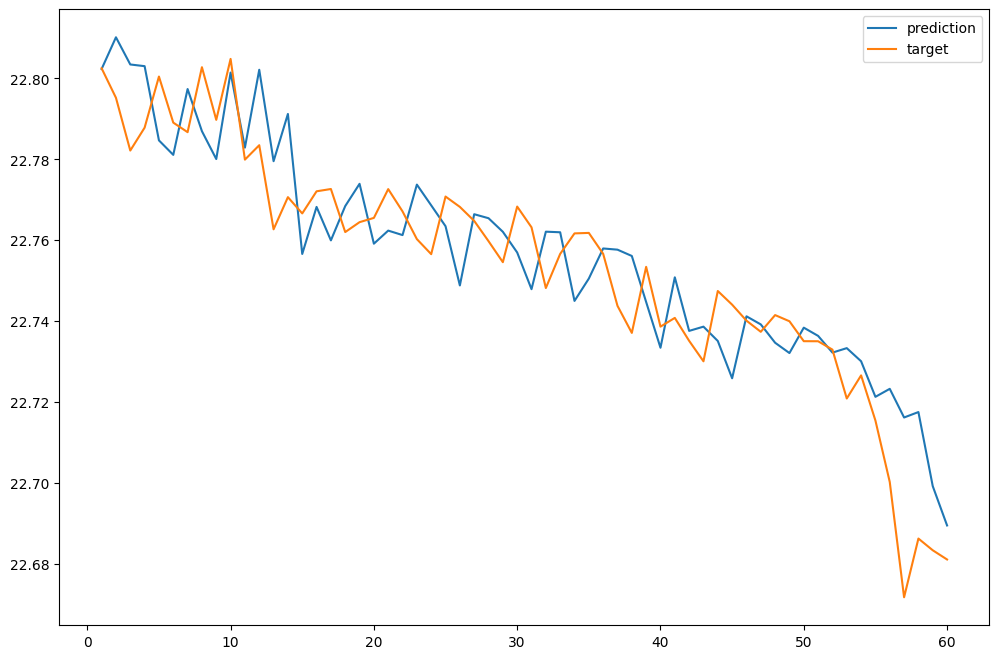

In [86]:
# target = data.iloc[-split:]
# target=list(target.values.reshape(-1))
# target = target[:4145]
# fig,axes = plt.subplots(1,1,figsize=(12,8))
# axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
# axes.plot(np.arange(1,61),target[-60:],label='target')
# axes.legend()

In [87]:
# print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item()*100,'%')
# print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item())
# print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item()*100,'%')

SMAPE 0.09511361131444573 %
RMSE 0.16837073862552643
MAPE 0.09409289923496544 %


In [ ]:
len(pred_list)

In [ ]:
pred_list

In [ ]:
target=list(target.values.reshape(-1))

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[61:121],label='prediction')
axes.plot(np.arange(1,61),target[:2821][61:121],label='target')
axes.legend()

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [ ]:
np.array(pred_list)

In [ ]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

In [ ]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

In [ ]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

In [ ]:
len(time_list)

In [ ]:
np.mean(time_list) 

In [ ]:
np.mean(time_list1) #pretraining 1Epoch 도는데 걸리는 시간